In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


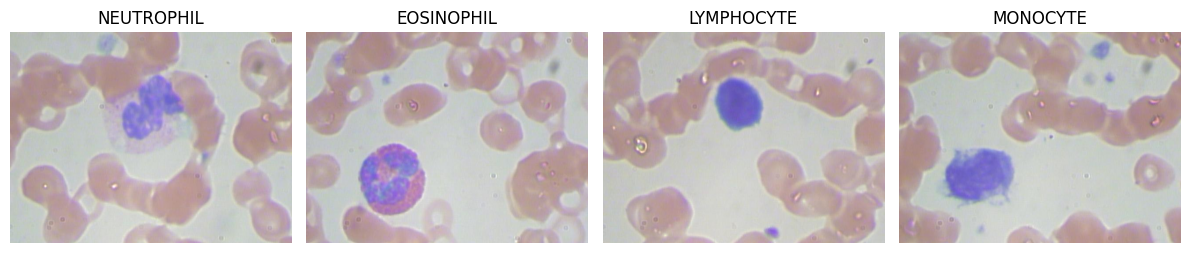

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter

# Define paths
dataset_path = "/content/drive/MyDrive/Q2_Data"  # Replace with your BCCD dataset path
classes = ["NEUTROPHIL", "EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE"]


# for cls in classes:
#     class_path = os.path.join(dataset_path, cls)
#     print(f"Contents of {class_path}:")
#     print(os.listdir(class_path) if os.path.exists(class_path) else "Folder not found.")

# Display one sample image per class
def display_sample_images():
    plt.figure(figsize=(12, 8))
    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        sample_image = os.listdir(class_path)[0]  # Get one image
        img = load_img(os.path.join(class_path, sample_image))
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_sample_images()


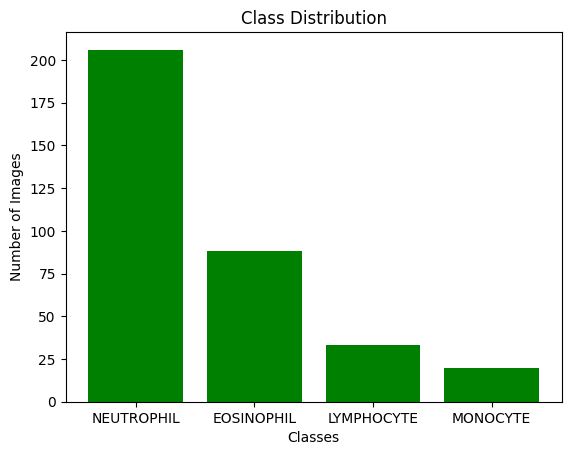

Class Counts: {'NEUTROPHIL': 206, 'EOSINOPHIL': 88, 'LYMPHOCYTE': 33, 'MONOCYTE': 20}
The dataset is imbalanced.


In [ ]:
# Check class distribution
def check_data_distribution():
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        class_counts[cls] = len(os.listdir(class_path))

    # Plot distribution
    plt.bar(class_counts.keys(), class_counts.values(), color='green')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()

    # Check if dataset is imbalanced
    print("Class Counts:", class_counts)
    max_count = max(class_counts.values())
    is_imbalanced = any(count < 0.8 * max_count for count in class_counts.values())
    if is_imbalanced:
        print("The dataset is imbalanced.")
    else:
        print("The dataset is balanced.")
    return class_counts

class_counts = check_data_distribution()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Data augmentation
def augment_data(target_count):
    augmented_path = "augmented_dataset"
    if not os.path.exists(augmented_path):
        os.makedirs(augmented_path)

    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        augmented_class_path = os.path.join(augmented_path, cls)
        if not os.path.exists(augmented_class_path):
            os.makedirs(augmented_class_path)

        images = os.listdir(class_path)
        gen = ImageDataGenerator(
            rescale=1.0 / 255,  # Normalize pixel values
            rotation_range=30,  # Random rotations
            zoom_range=0.2,     # Random zoom
            shear_range=0.2,    # Random shearing
            width_shift_range=0.2,  # Random horizontal shift
            height_shift_range=0.2,  # Random vertical shift
            horizontal_flip=True,  # Random horizontal flip
            vertical_flip=True,  # Random vertical flip
            brightness_range=[0.8, 1.2],  # Random brightness adjustment
            fill_mode='nearest'  # Fill pixels after transformation
        )

        # Augment until target_count is reached
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(224, 224))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            for batch in gen.flow(x, batch_size=1, save_to_dir=augmented_class_path, save_prefix=cls, save_format='jpeg'):
                if len(os.listdir(augmented_class_path)) >= target_count:
                    break

# Balance the dataset by augmenting
max_samples = max(class_counts.values())
for cls, count in class_counts.items():
    if count < max_samples:
        augment_data(max_samples)

print("Data augmentation completed.")


Data augmentation completed.


In [ ]:
from sklearn.model_selection import train_test_split
import shutil
import os

# Split dataset into training and validation
def split_dataset():
    train_path = "train_dataset"
    val_path = "val_dataset"

    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(val_path):
        os.makedirs(val_path)

    for cls in classes:
        augmented_class_path = os.path.join("augmented_dataset", cls)
        images = os.listdir(augmented_class_path)

        # Ensure you have enough samples for splitting
        if len(images) > 1:
            train_images, val_images = train_test_split(images, test_size=0.1, random_state=42)

            train_class_path = os.path.join(train_path, cls)
            val_class_path = os.path.join(val_path, cls)
            os.makedirs(train_class_path, exist_ok=True)
            os.makedirs(val_class_path, exist_ok=True)

            for img_name in train_images:
                shutil.copy(os.path.join(augmented_class_path, img_name), train_class_path)
            for img_name in val_images:
                shutil.copy(os.path.join(augmented_class_path, img_name), val_class_path)

    print(f"Data split completed: {len(train_images)} training, {len(val_images)} validation samples per class.")

split_dataset()



Data split completed: 236 training, 27 validation samples per class.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf


# Define paths
train_path = "train_dataset"
val_path = "val_dataset"
input_shape = (224, 224, 3)
batch_size = 16
# 32
num_classes = 4

# Data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


# Load Vision Transformer model "imagenet"
base_model = EfficientNetV2B0(weights= "imagenet", include_top=False, input_shape=input_shape, pooling="avg")
x = base_model.output
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)  # Add dropout layer
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dense(num_classes, activation="softmax")(x)

# x = base_model.output

# # Add fully connected layers with dropout, batch normalization, and L2 regularization
# x = Dense(512, kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)
# x = tf.keras.layers.Activation("relu")(x)
# x = Dropout(0.5)(x)  # Dropout to prevent overfitting
# x = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


Found 1639 images belonging to 4 classes.
Found 185 images belonging to 4 classes.
Class Weights: {0: 0.9802631578947368, 1: 1.5064338235294117, 2: 1.736228813559322, 3: 0.5746844319775596}
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 56, 56, 64)     │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 56, 56, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, 56, 56, 64)     │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, 56, 56, 32)     │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, 56, 56, 32)     │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 6,579,284 (25.10 MB)

 Trainable params: 6,517,652 (24.86 MB)

 Non-trainable params: 61,632 (240.75 KB)

In [ ]:
import numpy as np
def predict_and_visualize(mode_name, model):
    print(f"\nVisualizing predictions for {mode_name}...\n")
    # Reset the validation generator
    val_generator.reset()
    images, labels = next(val_generator)

    # Make predictions
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    # Class labels
    class_labels = list(val_generator.class_indices.keys())

    # Plot results
    plot_images = (images * 255).astype("uint8")
    plt.figure(figsize=(8, 6))
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(plot_images[i])
        true_label = class_labels[true_classes[i]]
        predicted_label = class_labels[predicted_classes[i]]
        color = "green" if true_classes[i] == predicted_classes[i] else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Early stopping, learning rate scheduler, and model checkpoint callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Set epochs to a larger number, as early stopping will control the end
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping],
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.4306 - loss: 1.3533
Epoch 1: val_loss improved from inf to 1.25931, saving model to best_model.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 155s 636ms/step - accuracy: 0.4315 - loss: 1.3510 - val_accuracy: 0.4375 - val_loss: 1.2593
Epoch 2/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.5625 - loss: 0.8975

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.25931
102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.5625 - loss: 0.8975 - val_accuracy: 0.2222 - val_loss: 1.2860
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6990 - loss: 0.7145
Epoch 3: val_loss improved from 1.25931 to 0.74538, saving model to best_model.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.6993 - loss: 0.7136 - val_accuracy: 0.7102 - val_loss: 0.7454
Epoch 4/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7500 - loss: 0.5232
Epoch 4: val_loss did not improve from 0.74538
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.7500 - loss: 0.5232 - val_accuracy: 0.5556 - val_loss: 0.9512
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8148 - loss: 0.4221
Epoch 5: val_loss did not improve from 0.74538
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8150 - loss: 0.4219 - val_accuracy: 0.5682 - val_loss: 1.0081
Epoch 6/50
  1/102 ━━━━━━━━━━━━━━━━━━

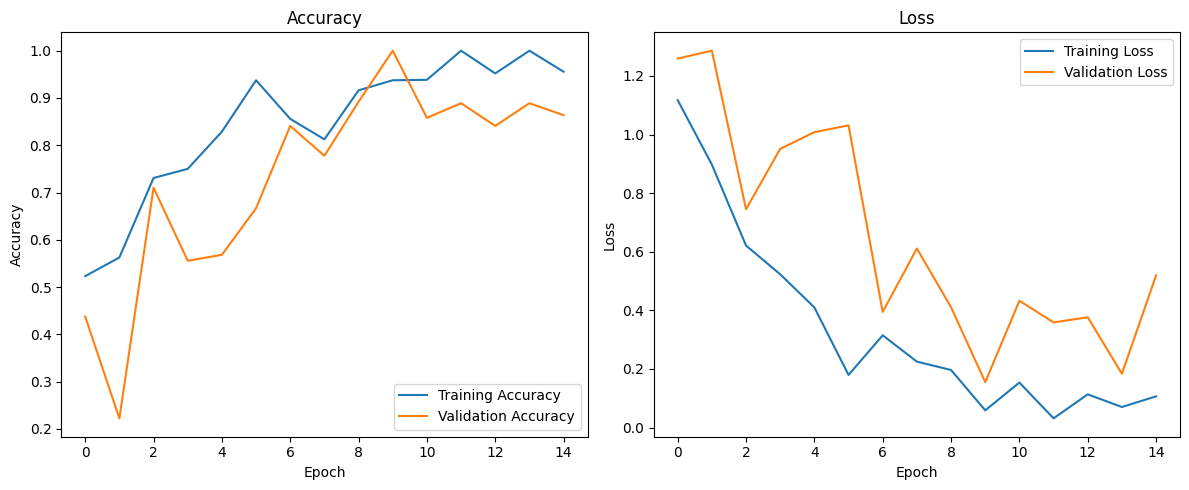

In [ ]:
# Plot accuracy and loss
def plot_metrics(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history)

In [ ]:
# Helper function to freeze/unfreeze layers
def set_trainable_layers(model, trainable_layers):
    for layer in model.layers:
        layer.trainable = False  # Freeze all layers by default
    for layer_name in trainable_layers:
        model.get_layer(layer_name).trainable = True
    print(f"Trainable layers: {[layer.name for layer in model.layers if layer.trainable]}")

# Calculate parameters
def calculate_parameters(model):
    total_params = model.count_params()
    trainable_params = sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params


Trainable layers: ['dense', 'dense_1']
Total parameters: 6579284
Trainable parameters: 657924
Non-trainable parameters: 5921360
Epoch 1/50
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9291 - loss: 0.2086
Epoch 1: val_loss did not improve from 0.15507
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 209ms/step - accuracy: 0.9291 - loss: 0.2082 - val_accuracy: 0.9034 - val_loss: 0.3858
Epoch 2/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8125 - loss: 0.2680
Epoch 2: val_loss did not improve from 0.15507
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8125 - loss: 0.2680 - val_accuracy: 0.7778 - val_loss: 0.7329
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9162 - loss: 0.1974
Epoch 3: val_loss did not improve from 0.15507
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9164 - loss: 0.1972 - val_accuracy: 0.8920 - val_loss: 0.4027
Epoch 4/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9375 - loss: 0.1292
Epoch 4: val_loss improved

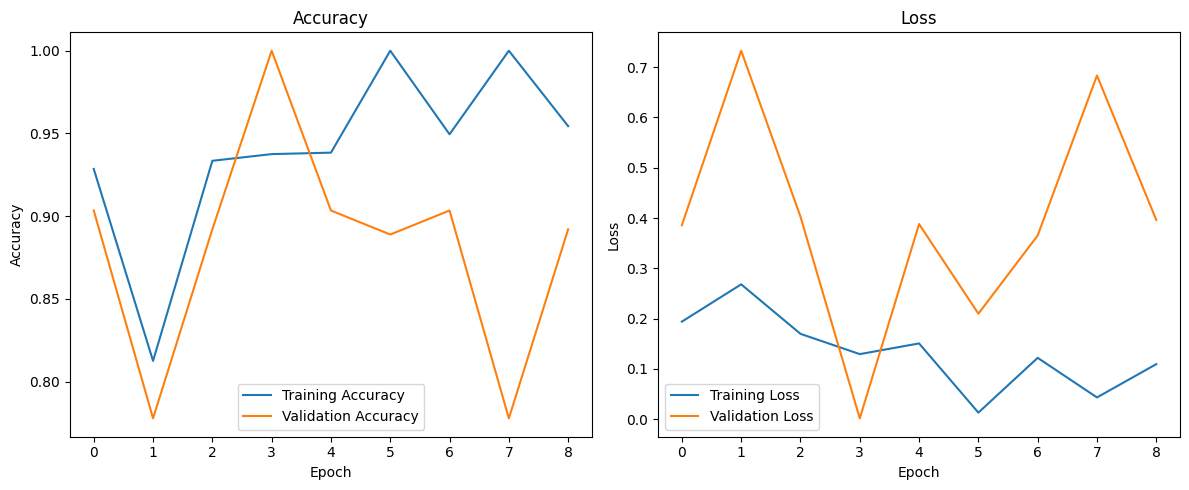

In [ ]:
from tensorflow.keras import backend as K

# Mode 1: Freeze all layers except the classifier
set_trainable_layers(model, ["dense", "dense_1"]) # Assuming dense layers are classifier layers
total_params, trainable_params, non_trainable_params = calculate_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 50
history_mode1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping],
)

plot_metrics(history_mode1)


In [ ]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name}")


0: input_layer
1: rescaling
2: normalization
3: stem_conv
4: stem_bn
5: stem_activation
6: block1a_project_conv
7: block1a_project_bn
8: block1a_project_activation
9: block2a_expand_conv
10: block2a_expand_bn
11: block2a_expand_activation
12: block2a_project_conv
13: block2a_project_bn
14: block2b_expand_conv
15: block2b_expand_bn
16: block2b_expand_activation
17: block2b_project_conv
18: block2b_project_bn
19: block2b_drop
20: block2b_add
21: block3a_expand_conv
22: block3a_expand_bn
23: block3a_expand_activation
24: block3a_project_conv
25: block3a_project_bn
26: block3b_expand_conv
27: block3b_expand_bn
28: block3b_expand_activation
29: block3b_project_conv
30: block3b_project_bn
31: block3b_drop
32: block3b_add
33: block4a_expand_conv
34: block4a_expand_bn
35: block4a_expand_activation
36: block4a_dwconv2
37: block4a_bn
38: block4a_activation
39: block4a_se_squeeze
40: block4a_se_reshape
41: block4a_se_reduce
42: block4a_se_expand
43: block4a_se_excite
44: block4a_project_conv
45: 

Trainable layers: ['block1a_project_conv', 'block2a_expand_conv', 'dense', 'dense_1']
Mode 2 - Total Parameters: 6579284, Trainable: 6
Total parameters: 6579284
Trainable parameters: 671748
Non-trainable parameters: 5907536
Epoch 1/50
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9467 - loss: 0.1162
Epoch 1: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 55s 252ms/step - accuracy: 0.9467 - loss: 0.1164 - val_accuracy: 0.8864 - val_loss: 0.3600
Epoch 2/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9375 - loss: 0.0627
Epoch 2: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9375 - loss: 0.0627 - val_accuracy: 0.8889 - val_loss: 0.8719
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9412 - loss: 0.1319
Epoch 3: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9413 - loss: 0.1317 - val_accuracy: 0.8864 - val_loss: 0.3806
Epoch 4/50
  1/10

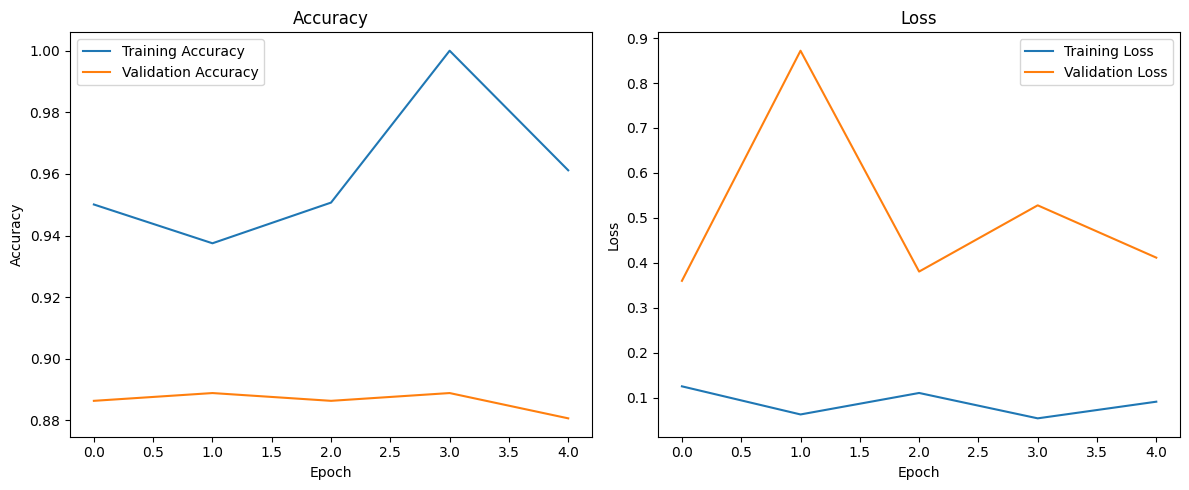

In [ ]:
# Mode 2: Fine-tune the first two encoder layers and the classifier
set_trainable_layers(model, ["block1a_project_conv", "block2a_expand_conv", "dense", "dense_1"])
print(f"Mode 2 - Total Parameters: {model.count_params()}, Trainable: {len(model.trainable_weights)}")

total_params, trainable_params, non_trainable_params = calculate_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

history_mode2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping],
)

plot_metrics(history_mode2)


Trainable layers: ['block6g_expand_conv', 'block6h_expand_conv', 'dense', 'dense_1']
Mode 3 - Total Parameters: 6579284, Trainable: 6
Total parameters: 6579284
Trainable parameters: 1100292
Non-trainable parameters: 5478992
Epoch 1/50
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9593 - loss: 0.0893
Epoch 1: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 50s 244ms/step - accuracy: 0.9593 - loss: 0.0894 - val_accuracy: 0.8864 - val_loss: 0.4086
Epoch 2/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9375 - loss: 0.0609
Epoch 2: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9375 - loss: 0.0609 - val_accuracy: 1.0000 - val_loss: 0.0846
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9533 - loss: 0.1012
Epoch 3: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9533 - loss: 0.1013 - val_accuracy: 0.8864 - val_loss: 0.4130
Epoch 4/50
  1/10

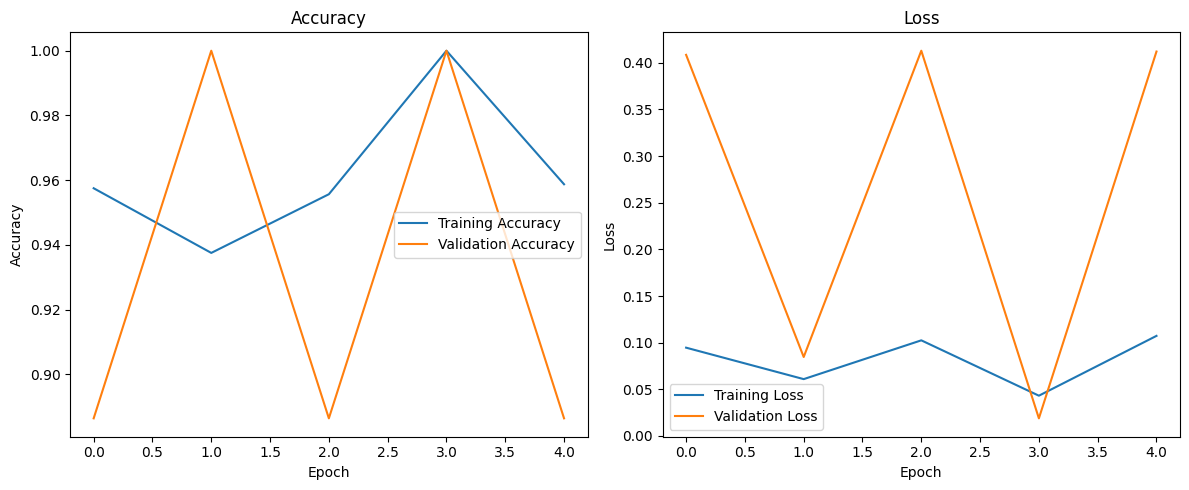

In [ ]:
# Mode 3: Fine-tune the last two encoder layers and the classifier
set_trainable_layers(model, ["block6h_expand_conv", "block6g_expand_conv", "dense", "dense_1"])
print(f"Mode 3 - Total Parameters: {model.count_params()}, Trainable: {len(model.trainable_weights)}")

total_params, trainable_params, non_trainable_params = calculate_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 50

history_mode3 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping],
)

plot_metrics(history_mode3)


Mode 4 - Total Parameters: 6579284, Trainable: 247
Total parameters: 6579284
Trainable parameters: 6517652
Non-trainable parameters: 61632
Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9294 - loss: 0.1377
Epoch 1: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 134s 542ms/step - accuracy: 0.9295 - loss: 0.1376 - val_accuracy: 0.8864 - val_loss: 0.3741
Epoch 2/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.0594
Epoch 2: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.0000 - loss: 0.0594 - val_accuracy: 1.0000 - val_loss: 0.0549
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9397 - loss: 0.1607
Epoch 3: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 52s 72ms/step - accuracy: 0.9397 - loss: 0.1606 - val_accuracy: 0.8750 - val_loss: 0.3863
Epoch 4/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9375 - loss: 0.1885
Epoch 4: val_

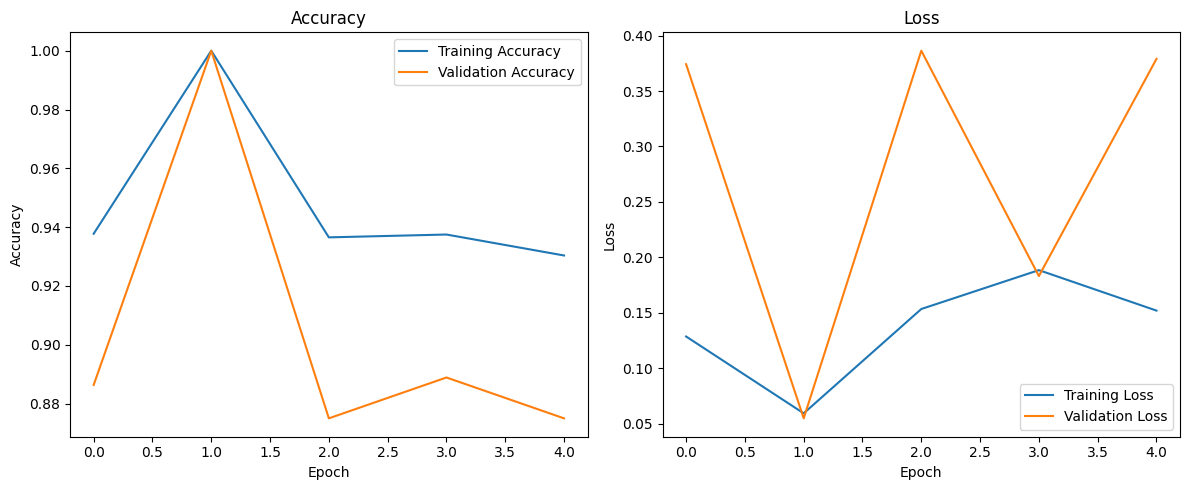

In [ ]:
# Mode 4: Fine-tune all layers
for layer in model.layers:
    layer.trainable = True
print(f"Mode 4 - Total Parameters: {model.count_params()}, Trainable: {len(model.trainable_weights)}")


total_params, trainable_params, non_trainable_params = calculate_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=1e-6), loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 50

history_mode4 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping],
)

plot_metrics(history_mode4)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,564,356 (28.86 MB)

 Trainable params: 7,480,708 (28.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5915 - loss: 0.9543
Epoch 1: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.5928 - loss: 0.9514 - val_accuracy: 0.7784 - val_loss: 0.6023
Epoch 2/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.8125 - loss: 0.4486
Epoch 2: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8125 - loss: 0.4486 - val_accuracy: 0.5556 - val_loss: 0.8181
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9393 - loss: 0.1783
Epoch 3: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.9393 - loss: 0.1782 - val_accuracy: 0.8636 - val_loss: 0.3543
Epoch 4/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.8750 - loss: 0.4368
Epoch 4: val_loss did not improve from 0.00143
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.8750 - loss: 0.4368 - val_accuracy: 0.7778 - val

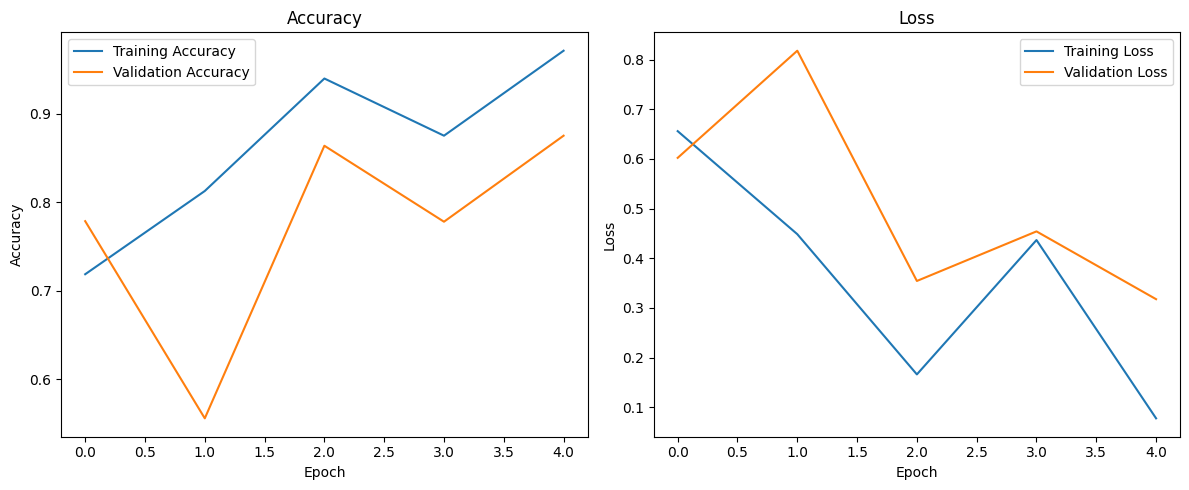

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

# Load DenseNet-121 base model
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling

# Add Dense layers with regularization and dropout
# x = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation="softmax")(x)

cnn_model = Model(inputs=base_model.input, outputs=x)
cnn_model.summary()

# Fine-tune the model: Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


# Train the CNN model
epochs = 50
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping],
)

plot_metrics(cnn_history)


In [ ]:
total_params = cnn_model.count_params()
trainable_params = sum([K.count_params(w) for w in cnn_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


Total parameters: 7564356
Trainable parameters: 7480708
Non-trainable parameters: 83648


Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - accuracy: 0.8828 - loss: 0.3165 - val_accuracy: 0.8920 - val_loss: 0.3500
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8750 - loss: 0.2692 - val_accuracy: 0.8889 - val_loss: 0.1604
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8830 - loss: 0.2967 - val_accuracy: 0.8920 - val_loss: 0.3092
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.8125 - loss: 0.4486 - val_accuracy: 0.8889 - val_loss: 0.2756
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8912 - loss: 0.2655 - val_accuracy: 0.8920 - val_loss: 0.3076
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.9375 - loss: 0.1218 - val_accuracy: 1.0000 - val_loss: 0.0874
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8994 - loss: 0.2529 - val_accuracy: 0.8864 - val_loss: 0.2940
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.9375 - loss: 0.2432 - va

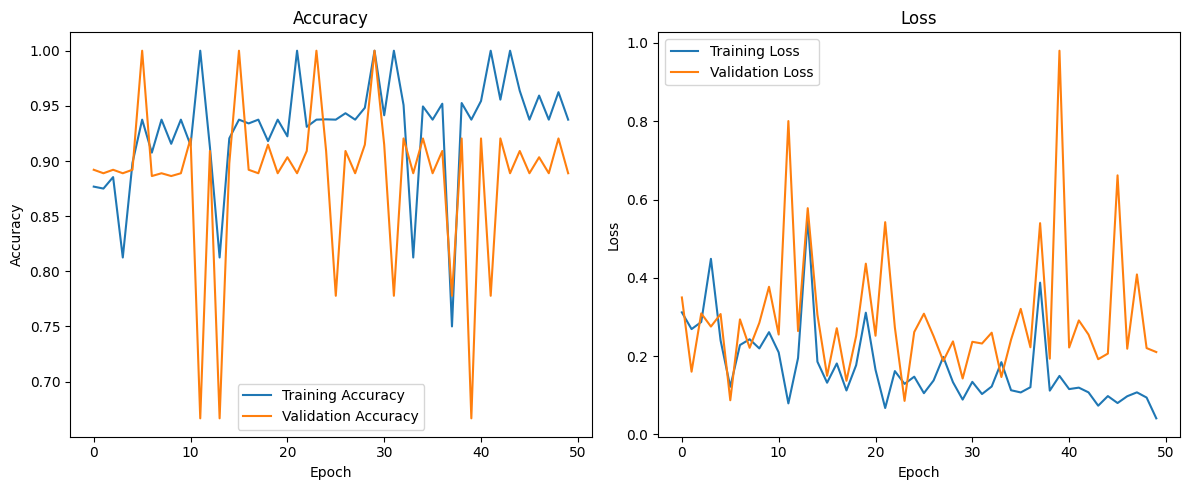

Validation Accuracy (CNN Classifier Only): 1.0
Validation Loss (CNN Classifier Only): 0.08578940480947495


In [ ]:
# Freeze all layers except the classifier
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers

# Only train classifier layers
cnn_model.layers[-1].trainable = True
cnn_model.layers[-2].trainable = True

cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 50
# Train the classifier-only model
classifier_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights,
)

plot_metrics(classifier_history)

# Evaluate and compare with ViT results
print("Validation Accuracy (CNN Classifier Only):", max(classifier_history.history["val_accuracy"]))
print("Validation Loss (CNN Classifier Only):", min(classifier_history.history["val_loss"]))
